# Overstory Candidate Assignment 
## *Theme*: Cloud Mask Segmentation
## *Candidate Name*: Ruben Colomina
## *Create at*: 10-10-2020

This notebook is the answer to assigment proposed by Overstory for a Data Engineer position. The goal for this task is to create a simple cloud mask (semantic segmentation) on satellite data images coming from Sentinel-2 mission.

The task will be split in the following sub-tasks:

- Install Dependencies
- Auxiliary Functions
- Download Data
- Data Exploration
- Data Preparation
- Model Selection
- Model Training / Testing
- Model Inferences

## Installing Dependencies


In [1]:
#!pip install pytorch
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install rasterio
!pip install matplotlib


Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Downloading Data

Sentinel-2 data shall be downloaded from amazon S3 buckets
The type of data to download will be TIF format files containing:
- RGB
- Multichannel Images
- Masks uint8

WARNING! All downloads require 30GB at least for all the multichannel data, and at least 6GB for RGB files.

In [2]:
#from google.colab import drive
#google_drive_mount_point='/content/drive'
#drive.mount(google_drive_mount_point)
#google_drive_path="drive/My\ Drive/SENTINEL2" # change this path accordanly pointing to google drive to target where files will be downloaded using wget

google_drive_path="/mnt/storage/sentinel2"


In [3]:
!ls -ltrh $google_drive_path | grep "RGB.tif" | grep -v mask

In [ ]:
# Download RGB tiles
!wget --content-disposition --trust-server-names -i https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/rgb_tiles.txt -P $google_drive_path

In [ ]:
# Donwload tif tiles
!wget --content-disposition --trust-server-names -i https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/tif_tiles.txt -P $google_drive_path

In [ ]:
# Download mask tiles
!wget --content-disposition --trust-server-names -i https://20tree-public.s3-eu-west-1.amazonaws.com/candidates/cloudmask/masks.txt -P $google_drive_path

## Auxiliary Functions

Functions to handle rasterio objects, cropping and/or plotting images from files or arrays.
These are useful to split data in low dimensional data points 64-256px. In this manner the machine learning models trained on

In [3]:
from matplotlib import pyplot as plt
import os
import rasterio
import numpy as np

def _ensure_opened(ds):
    "Ensure that `ds` is an opened Rasterio dataset and not a str/pathlike object."
    return ds if type(ds) == rasterio.io.DatasetReader else rasterio.open(str(ds), "r")


def read_crop(ds, crop, bands=None, pad=False):
    """
    Read rasterio `crop` for the given `bands`..
    Args:
        ds: Rasterio dataset.
        crop: Tuple or list containing the area to be cropped (px, py, w, h).
        bands: List of `bands` to read from the dataset.
    Returns:
        A numpy array containing the read image `crop` (bands * h * w).
    """
    ds = _ensure_opened(ds)
    if pad: raise ValueError('padding not implemented yet.')
    if bands is None:
        bands = [i for i in range(1, ds.count+1)]

    #assert len(bands) <= ds.count, "`bands` cannot contain more bands than the number of bands in the dataset."
    #assert max(bands) <= ds.count, "The maximum value in `bands` should be smaller or equal to the band count."
    window = None
    if crop is not None:
        assert len(crop) == 4, "`crop` should be a tuple or list of shape (px, py, w, h)."
        px, py, w, h = crop
        w = ds.width - px if (px + w) > ds.width else w
        h = ds.height - py if (py + h) > ds.height else h
        assert (px + w) <= ds.width, "The crop (px + w) is larger than the dataset width."
        assert (py + h) <= ds.height, "The crop (py + h) is larger than the dataset height."
        window = rasterio.windows.Window(px, py, w, h)
    meta = ds.meta
    meta.update(count=len(bands))
    if crop is not None:
        meta.update({
        'height': window.height,
        'width': window.width,
        'transform': rasterio.windows.transform(window, ds.transform)})
    return ds.read(bands, window=window), meta

def plot_rgb(img, clip_percentile=(2, 98), clip_values=None, bands=[3, 2, 1], figsize=(20, 20), nodata=None, figtitle=None, crop=None, ax=None):
    """
    Plot clipped (and optionally cropped) RGB image.
    Args:
        img: Path to image, rasterio dataset or numpy array of shape (bands, height, width).
        clip_percentile: (min percentile, max percentile) to use for clippping.
        clip_values: (min value, max value) to use for clipping (if set clip_percentile is ignored).
        bands: Bands to use as RGB values (starting at 1).
        figsize: Size of the matplotlib figure.
        figtitle: Title to use for the figure (if None and img is a path we will use the image filename).
        crop: Window to use to crop the image (px, py, w, h).
        ax: If not None, use this Matplotlib axis for plotting.
    Returns:
        A matplotlib figure.
    """
    meta = None
    if isinstance(img, str):
        assert os.path.exists(img), "{} does not exist!".format(img)
        figtitle = os.path.basename(img) if figtitle is None else figtitle
        img = rasterio.open(img)
        img, meta = read_crop(img, crop, bands)
    elif isinstance(img, rasterio.io.DatasetReader):
        img, meta = read_crop(img, crop, bands)
    elif isinstance(img, np.ndarray):
        assert len(img.shape) <= 3, "Array should have no more than 3 dimensions."
        if len(img.shape) == 2:
            img = img[np.newaxis, :, :]
        elif img.shape[0] > 3:
            img = img[np.array(bands) - 1, :, :]
        if crop is not None:
            img = img[:, py:py+h, px:px+w]
    else:
        raise ValueError("img should be str, rasterio dataset or numpy array. (got {})".format(type(img)))
    img = img.astype(float)
    nodata = nodata if nodata is not None else (meta['nodata'] if meta is not None else None)
    if nodata is not None:
        img[img == nodata] = np.nan
    if clip_values is not None:
        assert len(clip_values) == 2, "Clip values should have the shape (min value, max value)"
        assert clip_values[0] < clip_values[1], "clip_values[0] should be smaller than clip_values[1]"
    elif clip_percentile is not None:
        assert len(clip_percentile) == 2, "Clip_percentile should have the shape (min percentile, max percentile)"
        assert clip_percentile[0] < clip_percentile[1], "clip_percentile[0] should be smaller than clip_percentile[1]"
        clip_values = None if clip_percentile == (0, 100) else [np.nanpercentile(img, clip_percentile[i]) for i in range(2)]
    if clip_values is not None:
        img[~np.isnan(img)] = np.clip(img[~np.isnan(img)], *clip_values)
    clip_values = (np.nanmin(img), np.nanmax(img)) if clip_values is None else clip_values
    img[~np.isnan(img)] = (img[~np.isnan(img)] - clip_values[0])/(clip_values[1] - clip_values[0])
    if img.shape[0] <= 3:
        img = np.transpose(img, (1, 2, 0))
    alpha = np.all(~np.isnan(img), axis=2)[:,:,np.newaxis].astype(float)
    img = np.concatenate((img, alpha), axis=2)

    if not ax:
        figure, ax = plt.subplots(1, 1, figsize=figsize)
        ax.set_title(figtitle) if figtitle is not None else None
        ax.imshow(img)
        plt.close()
        return figure
    else:
        ax.imshow(img)

## Data Exploration

In [8]:
def print_different_values_bin(dataset):
  '''
  parameters:  dataset as numpy array
  description: calcualtes unique values of the input array in decimal and binary
  '''
  import numpy as np
  list_unique_values = np.unique(dataset)
  print("Unique decimal Values")
  print(list_unique_values)
  print("Unique binary Values")
  print([x for x in map(bin,list_unique_values.flatten() )])

In [7]:
# Select google drive or local
path_to_data="drive/My Drive/SENTINEL2" # path to google drive for python code
path_to_data='/mnt/storage/sentinel2'
import glob
XX = [i for i in glob.glob(path_to_data+"/tif_high/*.tif")] # selecting multi tile files
X = [i for i in glob.glob(path_to_data+"/tif_low/*RGB*.tif")] # selecting rgb tile files
Y = [i for i in glob.glob(path_to_data+"/tif_mask/*mask*tif")] # selecting mask tiles files
print(X[0],Y[0]) # show a sample pair
print(XX[0],len(XX))

/mnt/storage/sentinel2/tif_low/Sentinel2L2A_sen2cor_33TVF_20191104_clouds=37.8%_area=99%_RGB.tif /mnt/storage/sentinel2/tif_mask/cloud_mask_33TVF_20191104_clouds=84%.tif
/mnt/storage/sentinel2/tif_high/Sentinel2L2A_sen2cor_58KFC_20181021_clouds=1.2%_area=100%.tif 12


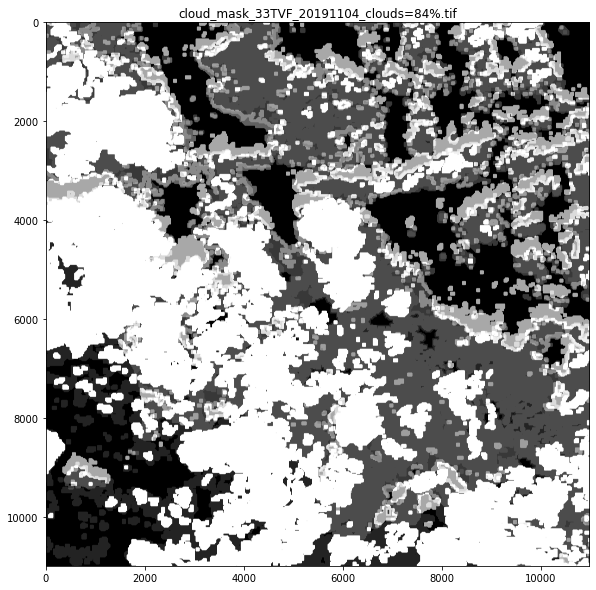

In [11]:
plot_rgb(Y[0], clip_values=(0,50), bands=[1,1,1], figsize=(10, 10))

In [12]:
# Printing different unique values existing on a mask sample
ds = _ensure_opened(Y[0])
crop_area = (0,0,10000,10000)
sub_ds, meta = read_crop(ds, crop=crop_area)
print_different_values_bin(sub_ds)

Unique decimal Values
[  0   1   3   7  11  15  19  23  27  31  33  35  39  43  47  51  55  59
  63 131 135 139 143 147 151 155 159 163 167 171 175 179 183 187 191]
Unique binary Values
['0b0', '0b1', '0b11', '0b111', '0b1011', '0b1111', '0b10011', '0b10111', '0b11011', '0b11111', '0b100001', '0b100011', '0b100111', '0b101011', '0b101111', '0b110011', '0b110111', '0b111011', '0b111111', '0b10000011', '0b10000111', '0b10001011', '0b10001111', '0b10010011', '0b10010111', '0b10011011', '0b10011111', '0b10100011', '0b10100111', '0b10101011', '0b10101111', '0b10110011', '0b10110111', '0b10111011', '0b10111111']


In [ ]:
# Showing a crop area from a target mask sample label
crop_area = (0,2000,2000,2000)
plot_rgb(Y[0], clip_values=(0,50), bands=[1,1,1], figsize=(10, 10),crop=crop_area)

In [ ]:
# Printing different unique values existing on a mask sample
ds = _ensure_opened(Y[0])
crop_area = (0,2000,2000,2000)
sub_ds, meta = read_crop(ds, crop=crop_area)
print_different_values_bin(sub_ds)
sub_ds, meta = read_crop(ds, crop=crop_area)

In [ ]:
# taking a close look to a mask samples
crop_area = (750,3500,200,200)
plot_rgb(Y[0], clip_values=(0,50), bands=[1,1,1], figsize=(10, 10),crop=crop_area)

In [ ]:
# Printing different unique values existing on a mask sample
crop_area = (750,3500,200,200)
sub_ds, meta = read_crop(ds, crop=crop_area)
print_different_values_bin(sub_ds)

In [ ]:
# Taking a look to a RGB crop area
bands=[3,2,1] 
ds = _ensure_opened(X[0])
(px, py, w, h) = 1000, 1000, 2000, 2000 #left, top, tilesize, tilesize
image, meta = read_crop(ds, (px, py, w, h), bands=bands)
#write it away as a file
with rasterio.open("testX.tif", 'w', **meta) as dst:
    dst.write(image)
#show it
fig = plt.figure(figsize=(10,10))
img = rasterio.open("testX.tif").read()
img = np.clip(img, 0, 2000) / 2000.0
plt.imshow(np.transpose(img, (1,2,0)))

## Data Preparation

In [8]:
def bitwise_2d(in_array_2d_uint,power_2): 
  '''
  parameters: 
  -in_array_2d: 2d array of uint, power_2: decimal power of 2
  returns: 
  -2d array formed by 0's,1's  (one hot encoding)
  '''   
  #print(in_array_2d_uint & power_2,power_2) #uncomment debug
  return ((in_array_2d_uint & power_2) > 0).astype(int)

def create_one_hot_encoder_2d(in_array_2d_uint):
  '''
  parameter: array (N,M) with uint 
  build 2d layers for each bit   
  return: array (N,M,8) one hot encoder 2D

  bit 0 (1) : all clouds except the thinnest and all shadows
  bit 1 (2) : all clouds (except the thinnest)
  bit 2 (4) : clouds detected via mono-temporal thresholds
  bit 3 (8) : clouds detected via multi-temporal thresholds
  bit 4 (16) : thinnest clouds
  bit 5 (32) : cloud shadows cast by a detected cloud
  bit 6 (64) : cloud shadows cast by a cloud outside image
  bit 7 (128) : high clouds detected by 1.38 µm 
  '''
  layers = [bitwise_2d(in_array_2d_uint,power_2) for power_2 in[2**i for i in range(0,8)]]
  return np.stack(layers,axis=-1) # stack on the last dimension
  
def pack_one_hot_encoder_2d(in_array_2d,axis=2):
  assert in_array_2d.shape[axis] == 8
  def packbin(x):
    return np.sum([2**i * x[i] for i in range(0,8)])
  return np.apply_along_axis(packbin, 2, in_array_2d)

In [ ]:
# testing one hot encoder 2d 
a = np.array([[1,4],[7,20]],dtype=np.uint8)
print(a)
b = create_one_hot_encoder_2d(a)
print(b.shape)
print(b)
b = create_one_hot_encoder_2d(a)
c = pack_one_hot_encoder_2d(b,axis=2)
print(c[0,0],c[0,1])
assert c[0,0] == 1 and c[0,1] == 4 and c[1,0] == 7 and c[1,1] == 20

In [9]:
# Path to google drive for python code
path_to_data = "drive/My Drive/SENTINEL2/"
# Path to data local
path_to_data = '/mnt/storage/sentinel2/'

import os
if not os.path.exists(path_to_data+"tiles_256"):
    os.makedirs(path_to_data+"tiles_256")

# DEFINE THE PATH WHERE GOOGLE DRIVE WILL BE CONTAINING THE TILES FILES
path_to_tiles = path_to_data+"tiles_256/"
# Number of files on origin
num_files = 12
# Pixels per tile
pixels = 256

In [10]:
def generate_tiles_from_tif(X,Y,idx_offset=0,num_files=12):
  '''
  parameters: 
  -X and Y are list of files paths the tif files, 
  -offset adds to the index of files when output filenames are saved

  This cropts images to reduce complexity on the model 
  and increase the number of samples for it, so it will be
  more generalisable
  WARNING! THIS PROCESS CAN TAKE A WHILE: Do once with the pixels size desired
  '''
  #assert idx_offset <= num_files
  
  for index,(x,y) in enumerate(zip(X[idx_offset:num_files],Y[idx_offset:num_files])):
    print(index+idx_offset,x,y)
    ds_x = _ensure_opened(x)
    ds_y = _ensure_opened(y)

    steps = int(ds_x.shape[0] / pixels)
    tiles = 1 # reset counter of number of tiles for a single filename
    total_tiles_per_file = (steps-1)**2
    print("Num. crops per image", total_tiles_per_file) 
    for i in range(0,steps-1):
      for j in range(0,steps-1):
        crop = (pixels * i, 
                pixels * j, 
                pixels,pixels)
      
        # Cropping areas on TIF files 
        image_rgb, meta  = read_crop(ds_x, crop)
        image_mask, meta = read_crop(ds_y, crop)

        image_rgb_npy   = path_to_tiles+f"tile_rgb_px_{pixels}_f_{index+idx_offset}_i_{i}_j_{j}.npy"
        image_mask_npy  = path_to_tiles+f"tile_mask_px_{pixels}_f_{index+idx_offset}_i_{i}_j_{j}.npy"

        np.save(image_rgb_npy,image_rgb)
        image_one_hot_encoder_2d = create_one_hot_encoder_2d(image_mask.squeeze())
        np.save(image_mask_npy,image_one_hot_encoder_2d)

        print("num file",index+idx_offset,"stored tile",tiles,
              " out of ",total_tiles_per_file," total tiles "," - crop window",crop)
        tiles+=1
  print("End of the tiles generation")
  return None
  #

In [17]:
!ls $google_drive_path/tiles_256 | grep "tile_rgb*npy" | wc

      0       0       0


In [ ]:
import glob
X = [i for i in glob.glob(path_to_data+"/tif_low/*RGB*.tif")] # selecting rgb tile files
Y = [i for i in glob.glob(path_to_data+"/tif/mask/*mask*tif")] # selecting mask tiles files
print(X[0],Y[0]) # show a sample pair
X.sort()
Y.sort()

print(len(X))
print(X[-1],X[11])
generate_tiles_from_tif(X,Y,idx_offset=7)

for num_f in range(0,12):
  counting_rgb = [i for i in glob.glob(path_to_data+"/tiles_256/tile_rgb*_f_0_*.npy")]
  counting_mask = [i for i in glob.glob(path_to_data+"/tiles_256/tile_mask*_f_0_*.npy")]
  print(num_f,len(counting_rgb),len(counting_mask))
  assert len(counting_mask) == 1681 and len(counting_rgb) == 1681

In [12]:
# Build Cloud data set from Dataset
import numpy as np
import glob
import torch
from torch.utils.data import Dataset, DataLoader

class CloudDataset(Dataset):
  '''
  This class wraps tourch Dataset

  '''
  def __init__(self, data_dir, 
               scale_factor = 10000, 
               pytorch=True,
               max_num_tiles=1000):
    super().__init__()

    self.scale_factor = scale_factor # for normalisation    
    
    self.files_mask = glob.glob(data_dir+"/*mask*") # only selecting masks
    self.files_rgb  = glob.glob(data_dir+"/*rgb*")  # only selecting rgb
    self.files_tif  = glob.glob(data_dir+"/*%.tif") # only selecting tif

    self.pytorch = pytorch

  def _stats(self,img):
    print("std",np.std(img),"max",np.max(img),"min",np.min(img))

  def _packbits_mask(self,mask_as_array):
    return pack_one_hot_encoder_2d(mask_as_array,axis=2)

  def open_mask_as_array(self, idx):
    return np.load(self.files_mask[idx])

  def open_mask_as_img(self, idx):
    mask_array = self.open_mask_as_array(idx)
    return self._packbits_mask(mask_array) / 255 

  def open_as_array(self, idx): 
    '''
    Load files from npy clipping and scaling the array to [0-1] 
    '''
    raw_rgb = np.load(self.files_rgb[idx])
    raw_rgb_norm = np.clip(raw_rgb, 0, self.scale_factor) / self.scale_factor
    raw_rgb_norm = raw_rgb_norm.astype(np.float32)
    return raw_rgb_norm

  def __getitem__(self, idx, rgb = True):
    '''
    Returns pairs x,y for the data loader
    '''
    raw_mask = np.load(self.files_mask[idx])
    # bringing channels to the last dimension instead first
    raw_mask = raw_mask.transpose((2,0,1))
    x = torch.tensor(self.open_as_array(idx))
    y = torch.tensor(raw_mask)

    return x, y    

  def __len__(self):         
    return len(self.files_mask)

  def __repr__(self):
    s = 'Dataset class with {} files'.format(self.__len__())
    return s    

  def open_rbg_as_img(self,idx):
    img = self.open_as_array(idx)
    print("Output from open_as_array")
    self._stats(img)
    rgb_denorm = np.transpose(img, (1,2,0))
    #print(np.max(rgb_denorm),np.min(rgb_denorm))
    return rgb_denorm

# Instanciate from generated tiles
scale_factor = 8000  # this must be big enought to avoid saturation
dataset = CloudDataset(path_to_tiles, scale_factor=scale_factor)
print(dataset)
x, y = dataset[0]
print(x.shape,y.shape)
print(dataset.files_rgb[0])

Dataset class with 20172 files
torch.Size([3, 256, 256]) torch.Size([8, 256, 256])
/mnt/storage/sentinel2/tiles_256/tile_rgb_px_256_f_7_i_39_j_31.npy


Output from open_as_array
std 0.13006446 max 1.0 min 0.063875
Output from open_as_array
std 0.13860895 max 0.7355 min 0.04825
Output from open_as_array
std 0.17584313 max 1.0 min 0.05725
Output from open_as_array
std 0.020668602 max 0.2425 min 0.01175
Output from open_as_array
std 0.104000054 max 0.6415 min 0.000125


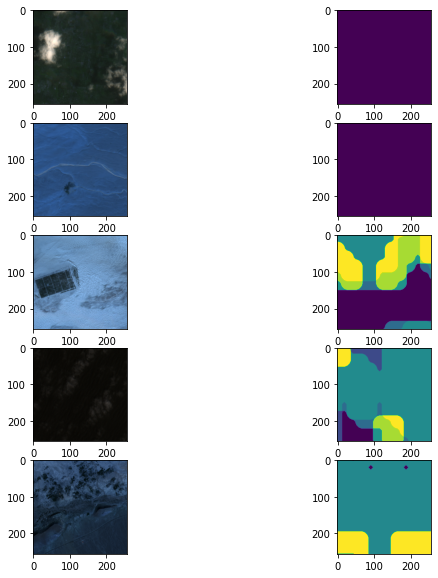

In [29]:
# Checking pairs of imagesairs of tails to check out how it looks single x,y samples of the dataset
import matplotlib.pyplot as plt
num_clips = 5
fig, ax = plt.subplots(num_clips,2, figsize=(10,10))
idx = 5000
for i in range(0,num_clips):
    ax[i,0].imshow(dataset.open_rbg_as_img(idx+i))
    ax[i,1].imshow(dataset.open_mask_as_img(idx+i))


In [13]:
from torch.utils.data import random_split

# SPLIT DATASET INI TRAIN / TEST subdatasets
split_percent = 0.9

len_data  = len(dataset)
len_train = int(len_data * split_percent)
len_test  = len_data - len_train
lengths = [len_train,len_test]
train_ds, test_ds = random_split(dataset, lengths)

print("length train = ",len(train_ds)," | length test = ",len(test_ds))

# CREATE A DATA LOADER WITH MINIBATCHES OF DATA
shuffle = True # data will be shuffle after each epoch
batch_size = 50
print("Shuffle is ",shuffle," | Batch Size = ",batch_size)

print("Creating training a validation data loaders")
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=shuffle)
valid_dl = DataLoader(test_ds,  batch_size = batch_size, shuffle=shuffle)

xb, yb = next(iter(train_dl))
print(xb.shape,yb.shape)


length train =  18154  | length test =  2018
Shuffle is  True  | Batch Size =  50
Creating training a validation data loaders
torch.Size([50, 3, 256, 256]) torch.Size([50, 8, 256, 256])


## Model Selection

UNET is a popular semantic segmentation method, which includes interesting aspects on its architectures, such as skip connections and bottleneck. It is an auto-encoder with these type of bridges which increse resolution on the output. In this job, a simple UNET model without bottleneck has been choose, since it will require less amount of data to converge to a good enough solution.

In [14]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)
    def __call__(self, x):
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        return upconv1
    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                            stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, 
                            stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )
        return contract
    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 
                                               kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, 
                                            kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, 
                                                     kernel_size=3, stride=2, 
                                                     padding=1, output_padding=1) 
                            )
        return expand

In [15]:
unet = UNET(3,8)
#print("Performing a Interation on UNET")
#xb ,yb = next(iter(train_dl))
#print(xb.shape,yb.shape)

In [ ]:
pred = unet(xb)
print("input shape",xb.shape)
assert pred.shape == torch.Size([batch_size, 8, 256, 256])
print("prediction dim",pred.shape)
print("labels dim",yb.shape)
print(pred[0].shape)
print(yb[0].shape)
loss_fn = nn.CrossEntropyLoss()

loss = 0.0
for i in range(0,8):
  loss_bit = loss_fn(pred,yb[:,i,:,:])
  loss += loss_bit
print(loss)

(pred.argmax(dim=1) == yb[:,0,:,:]).float().mean()

loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input)
print(input.shape)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)
print(target.shape)
output = loss(input, target)
output.backward()
print(output)

input shape torch.Size([20, 3, 256, 256])
prediction dim torch.Size([20, 8, 256, 256])
labels dim torch.Size([20, 8, 256, 256])
torch.Size([8, 256, 256])
torch.Size([8, 256, 256])
tensor(17.0038, grad_fn=<AddBackward0>)
tensor([[ 1.4879, -0.5693,  2.2687,  1.9475,  2.9111],
        [-1.9178,  0.3613, -0.0316, -1.1582, -0.0546],
        [-0.6840,  0.7860,  0.1061, -0.9364, -0.3853]], requires_grad=True)
torch.Size([3, 5])
tensor([2, 3, 2])
torch.Size([3])
tensor(1.7991, grad_fn=<NllLossBackward>)


## Motel Training

In [16]:
def acc_metric(predb, yb):
  acc = 0.0
  for bit in range(0,8):
    acc+=(predb.argmax(dim=1) == yb[:,bit,:,:].cuda()).float().mean() 
  return acc / 8.0 # we are comparing 8 bit channels

In [17]:
import time
def train(model, train_dl, valid_dl, 
          loss_fn, optimizer, acc_fn, epochs=1):
  
    start = time.time()
    model.cuda()
    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        msg = 'Epoch {}/{}'.format(epoch, epochs - 1)
        print(msg) #'Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * len(msg))
        for phase in ['train', 'valid']:
            print("Starting Phase:",phase)
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)

                    #loss = loss_fn(outputs, y)
                    loss = 0.0 
                    for i in range(0,8): # calculate loss on each bit mask
                      loss += loss_fn(outputs,y[:,i,:,:])

                    #print("loss calculated",loss)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()
                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = 0.0
                        for i in range(0,8): # calculate loss on each bit mask
                          loss += loss_fn(outputs,y[:,i,:,:])

                        #loss = loss_fn(outputs, y.long()) # fix this for validation

                # stats - whatever is the phase
                #print("calculate accuracy")
                acc = acc_fn(outputs, y)   

                print(f"Step {step} Accuracy {acc} Loss {loss}")
                running_acc  += acc  * dataloader.batch_size
                running_loss += loss * dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, 
                                                                                          torch.cuda.memory_allocated()/1024/1024))
                    #print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    print(f'Saving Model in {path_to_model}')
    torch.save(model.state_dict(), path_to_model)

    return train_loss, valid_loss    



In [39]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(),lr=0.01)
model = unet

path_to_model=path_to_data+"/models"
assert os.path.isdir(path_to_model)
epochs = 2
train_loss, valid_loss = train(model, train_dl, valid_dl, 
                               loss_fn, opt, acc_metric, epochs=epochs) 

Epoch 0/1
---------
Starting Phase: train


RuntimeError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 7.76 GiB total capacity; 6.75 GiB already allocated; 117.94 MiB free; 6.76 GiB reserved in total by PyTorch)

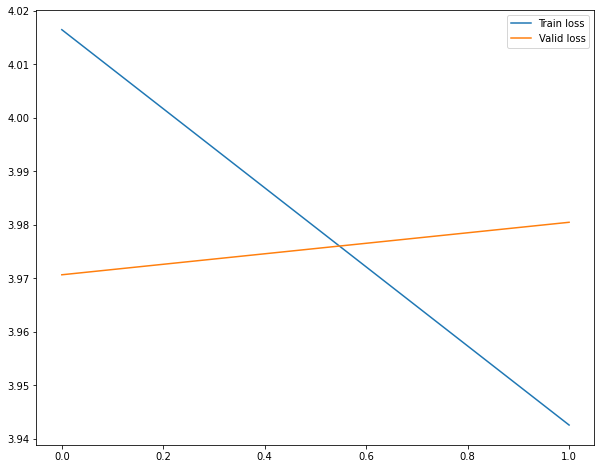

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

input image shape (3, 1024, 1024)
stats after clip 188.39786186488334 1024
stats after clip and scale down 0.18398228697742514 1.0
(3, 1024, 1024)
(1024, 1024, 3)


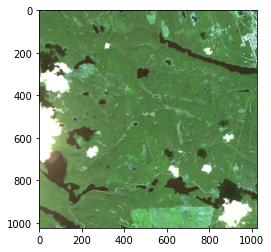

In [ ]:
scale_factor = 1024
def imshow(img):
    print("input image shape",img.shape) 
    img_clip = np.clip(img, 0, scale_factor)
    print("stats after clip",np.std(img_clip),np.max(img_clip))
    img = np.clip(img, 0, scale_factor) / scale_factor
    #print(img.shape)
    print("stats after clip and scale down",np.std(img),np.max(img))

    np.transpose(img, (1,2,0))
    print(img.shape)
    print(np.transpose(img, (1,2,0)).shape)
    plt.imshow(np.transpose(img, (1,2,0)))
   

filename = path+"tile_rgb_px_1024_f_0_i_0_j_0.npy"
a = np.load(filename)
imshow(a) 


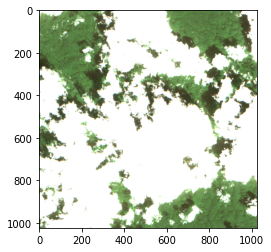

In [ ]:
filename = path+"tile_rgb_px_1024_f_1_i_0_j_2.npy"
a = np.load(filename)
imshow(a) 